In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
import numpy as np
import pandas as pd
import catboost

from catboost import cv, Pool
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [3]:
days_from_start = {
    1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181,
    8: 212, 9: 243, 10: 273, 11: 304, 12: 334
}

days_in_month = {
    1: 31,  2: 28,  3: 31,  4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30,  10: 31, 11: 30, 12: 31
}

params =  {
    "random_seed": 17,
    "eval_metric": "AUC"
    
}

season_from_moth = {12: "winter", 1: "winter", 2: "winter",
                    3: "spring", 4: "spring", 5: "spring", 
                    6: "summer", 7: "summer", 8: "summer", 
                    9: "autumn", 10: "autumn", 11: "autumn"
                   }

weekend = {1: 0, 2: 0,  3: 0, 4: 0, 5: 0, 6: 1, 7: 1 }

In [4]:
def encode_and_cat(data):
    for name in encode_names:
        data[name] = pd.factorize(data[name])[0]
        
    for name in cat_names:
        data[name] = data[name].astype('category')    

In [5]:
def extend_name(name):
    cat_names.extend([name])
    encode_names.extend([name])

In [370]:
cat_names = "Month DayofMonth DayOfWeek UniqueCarrier Origin Dest flight hour".split()

encode_names = "UniqueCarrier Origin Dest flight".split()

def clean_data(data):
    for name in ['Month', 'DayofMonth', 'DayOfWeek']:
        data[name] = data[name].str[2:].astype(int)
    
    data["minutes"] = data.DepTime % 100
    data['min_bin'] = pd.cut(data['minutes'], bins=np.arange(0, 60, 10),
                             include_lowest=True)
    extend_name("min_bin")
    
    data["days_in_m"] = data.Month.map(days_in_month)
    
    data.DayofMonth = data.DayofMonth + data.DepTime // 2400
    data.DayOfWeek = data.DayOfWeek + data.DepTime // 2400
    data.Month = data.Month + data.DayofMonth // (data.days_in_m + 1)
    
    data.DayofMonth = data.DayofMonth % (data.days_in_m)
    data.loc[data['DayofMonth'] == 0, 'DayofMonth'] = data.loc[data['DayofMonth'] == 0, 'days_in_m']
    
    data.DayOfWeek = data.DayOfWeek % 7
    data.loc[data['DayOfWeek'] == 0, 'DayOfWeek'] = 7
    
    data.DepTime = data.DepTime % 2400
    # data.loc[data['DepTime'] == 0, 'DepTime'] = 2400
    

    data["hour"] = data.DepTime // 100
    
    data["dep_t"] = data.hour * 60 + data.DepTime % 100 # some accturacy on cv
    
    data['sin_dep'] = np.sin(2 * np.pi * data.dep_t / (24 * 60))
    data['cos_dep'] = np.cos(2 * np.pi * data.dep_t / (24 * 60))    
    
    data["sin_min"] = np.sin(2 * np.pi * data.minutes / 59)
    data["cos_min"] = np.cos(2 * np.pi * data.minutes / 59)
    
    data.Distance = np.power(np.log10(data.Distance), 2)
    
    data["flight"] = data.Origin + "_" + data.Dest
    
    data["days"] = data.Month.map(days_from_start) + data.DayofMonth
    
    data["sin_days"] = np.sin(2 * np.pi * data.days / 365)
    data["cos_days"] = np.cos(2 * np.pi * data.days / 365)
    
    """
    data["flight_min"] = data.flight + "_" + data.min_bin.astype(str)
    extend_name("flight_min")
    """    
    
    data.drop(["DepTime", "days_in_m", "minutes", "dep_t", "days"],
              axis=1, inplace=True)
    

In [373]:
df = pd.read_csv('../../data/flight_delays_train.csv')
y_train = df['dep_delayed_15min'].map({'Y': 1, 'N': 0})
df.drop("dep_delayed_15min", axis=1, inplace=True)

test_df = pd.read_csv('../../data/flight_delays_test.csv')

df.head(2)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834


In [374]:
full_df = pd.concat((df, test_df))

clean_data(full_df)
encode_and_cat(full_df)

split = df.shape[0]

X_valid, X_test = full_df[:split].values, full_df[split:].values

cat_i = np.where(full_df.dtypes == 'category')[0]
cat_i
full_df.shape
full_df.head(2)

array([ 0,  1,  2,  3,  4,  5,  7,  8, 13], dtype=int64)

(200000, 16)

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,min_bin,hour,sin_dep,cos_dep,sin_min,cos_min,flight,sin_days,cos_days
0,8,21,7,0,0,0,8.205424,0,19,-0.917060,0.398749,-0.461093,-0.887352,0,-0.763889,-0.645348
1,4,20,3,1,1,1,8.533211,1,15,-0.838671,-0.544639,-0.921312,0.388824,1,0.948362,-0.317191


In [375]:
%%time

test_score = []
train_score = []

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

i = 0
for test_index, train_index in skf.split(X_valid, y_train):
    print("| ", end="")
    
    X_train_1, X_test_1 = X_valid[train_index, :], X_valid[test_index, :]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    
    
    ctb = CatBoostClassifier(random_seed=17,
                              silent=True
                             ).fit(X_train_1, y_train_1, cat_features=cat_i)
    
    test_score.append(
        roc_auc_score(y_test_1, ctb.predict_proba(X_test_1)[:, 1]))
    
    train_score.append(roc_auc_score(y_train_1, ctb.predict_proba(X_train_1)[:, 1]))
    
    i += 1
    print(i, end = " ")
    

| 1 | 2 | 3 Wall time: 4min 41s


In [377]:
iter_ = list(iter_)

In [378]:
iter_.append((round(np.mean(train_score), 4), round(np.mean(test_score), 4)))

In [379]:
iter_[-1]

(0.9144, 0.7685)

In [388]:
# drop origin_min
print(round(np.mean(train_score), 4), " - train score")
print(round(np.mean(test_score), 4), " - test score")
print(*sorted(zip(ctb.get_feature_importance(), full_df.columns), reverse=True), sep="\n")

0.9144  - train score
0.7685  - test score
(21.141507016338025, 'hour')
(13.875296387835723, 'flight')
(9.695579390226891, 'UniqueCarrier')
(8.035834061704842, 'min_bin')
(7.874538123410779, 'sin_dep')
(6.0747787485753575, 'Origin')
(4.824828455756504, 'Dest')
(4.619214224866855, 'sin_min')
(4.102147271744903, 'cos_dep')
(3.6398445569281646, 'Distance')
(3.293015194311452, 'cos_days')
(2.858065901977463, 'Month')
(2.6045688222212466, 'DayofMonth')
(2.598079856618949, 'sin_days')
(2.5800029426788713, 'DayOfWeek')
(2.182699044804152, 'cos_min')


In [307]:
# origin_min
print(round(np.mean(train_score), 4), " - train score")
print(round(np.mean(test_score), 4), " - test score")
print(*sorted(zip(ctb.get_feature_importance(), full_df.columns), reverse=True), sep="\n")

0.9394  - train score
0.7725  - test score
(24.41644959195692, 'hour')
(11.813373066259313, 'sin_dep')
(7.958852085167953, 'cos_dep')
(7.300096528418177, 'Dest')
(6.672403090887884, 'UniqueCarrier')
(6.278287763367352, 'origin_min')
(4.318601280377706, 'Origin')
(4.124674598522157, 'flight')
(3.9455194373867926, 'cos_days')
(3.738815975268189, 'Month')
(3.5325530759717427, 'DayOfWeek')
(3.2042661722091728, 'sin_days')
(3.1465857352212514, 'Distance')
(3.0623879916930083, 'DayofMonth')
(2.768121212863839, 'min_bin')
(2.0665879203046194, 'sin_min')
(1.6524244741239604, 'cos_min')


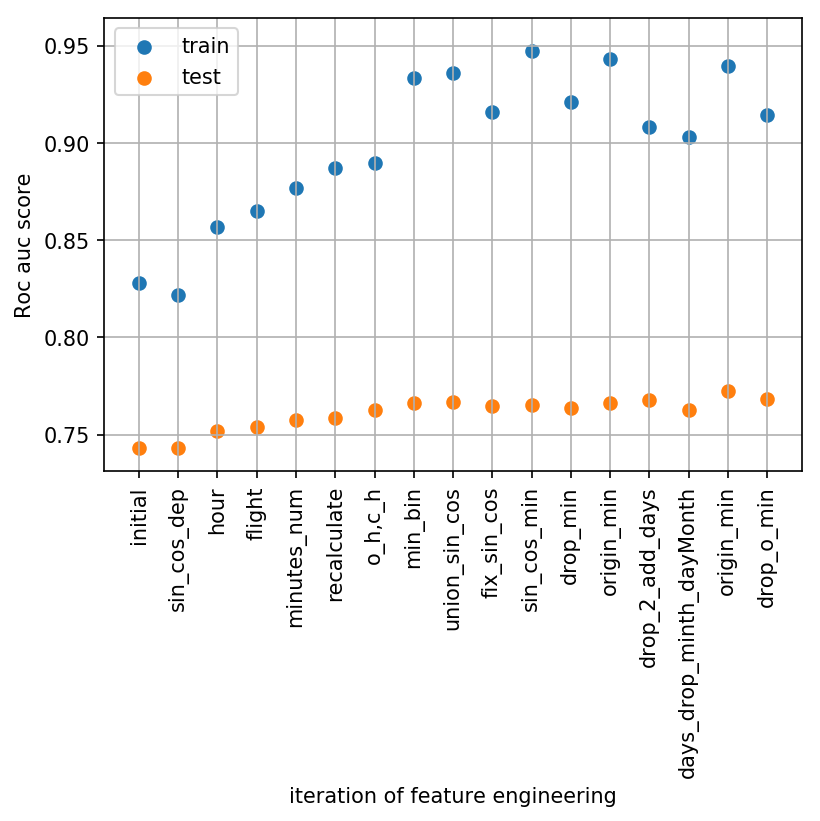

In [389]:
iter_ = np.array(iter_)
x = np.arange(len(iter_))
plt.figure(dpi=150)
plt.scatter(x, iter_[:, 0], label="train");
plt.scatter(x, iter_[:, 1], label="test");
plt.ylabel("Roc auc score");
plt.xlabel("iteration of feature engineering");
plt.xticks(x, x_ticks.split(), rotation=90)
plt.grid(True)
plt.legend();

In [376]:
x_ticks = \
'''
initial sin_cos_dep hour flight minutes_num recalculate
o_h,c_h min_bin union_sin_cos fix_sin_cos sin_cos_min drop_min
origin_min drop_2_add_days days_drop_minth_dayMonth origin_min drop_o_min
'''


In [296]:
iter_ = [[0.828 , 0.7429], # initial 
[0.8218, 0.7433], # -- add sin cos min, drop changed Deptime
[0.857 , 0.752 ], # -- add hour as cat
[0.865 , 0.7538], # -- add flight
[0.8769, 0.7577], # -- add minutes as num
[0.8871, 0.7583], # -- hour, minute, sin cos of chancheg deptime - beat baseline /// 
[0.8895, 0.7626], # -- origin_h, carrier_h - 0.75797
[0.9335, 0.766 ], # -- drop early, add min_bin - 0.76
[0.9358, 0.767 ], # -- union sin cos (minutes)
[0.9158, 0.7649], # -- some fix, sin cos for deptime
[0.9471, 0.7651], # -- add sin cos for min 
[0.9213, 0.7638], # -- drop min ///
[0.9432, 0.7661], # -- origin min  || looks like overfittin
[0.9082, 0.7680], # -- add days; drop 2 step 
[0.9033, 0.7628], # -- sin cos days, drop month, dayOfMoth
        
]


In [382]:
iter_ = np.array(iter_)
iter_

array([[0.828 , 0.7429],
       [0.8218, 0.7433],
       [0.857 , 0.752 ],
       [0.865 , 0.7538],
       [0.8769, 0.7577],
       [0.8871, 0.7583],
       [0.8895, 0.7626],
       [0.9335, 0.766 ],
       [0.9358, 0.767 ],
       [0.9158, 0.7649],
       [0.9471, 0.7651],
       [0.9213, 0.7638],
       [0.9432, 0.7661],
       [0.9082, 0.768 ],
       [0.9033, 0.7628],
       [0.9394, 0.7725],
       [0.9144, 0.7685]])

In [384]:
%%time
ctb.fit(X_valid, y_train,
        cat_features=cat_i);

Wall time: 2min 36s


In [385]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]
roc_auc_score(y_train, ctb.predict_proba(X_valid)[:, 1])

0.9712735822308832

In [386]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv('../../data/sample_submission.csv', 
                             index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('try_drop_o_h.csv')